In [1]:
'''
# to create dataset
read_line = open('./CUB_200_2011_updated/train_test_split.txt')
train_test_split = read_line.readlines()

classes = open('./CUB_200_2011_updated/classes.txt')
c_names = classes.readlines()
for i in range(len(c_names)):
    c_names[i] = c_names[i].split(' ')[1]
    
import os
for i in range(len(c_names)):
    os.makedirs('./test/'+c_names[i].split('\n')[0])
    
train_dataset = datasets.ImageFolder('./CUB_200_2011_updated/images')
#len(train_dataset.imgs)
for j in range(len(train_dataset.imgs)):
    if(train_test_split[j].split(' ')[1].split('\n')[0] == '0'):
        path = train_dataset.imgs[j][0]
        img = io.imread(path)
        folder = train_dataset.imgs[j][0].split('/')[3]
        img_name = train_dataset.imgs[j][0].split('/')[4]
        io.imsave('./test/'+folder+'/'+img_name,img)
        os.remove(path)
!mv ./CUB_200_2011_updated/images ./train
''';

In [2]:
#imports
from heapq import nsmallest
from operator import itemgetter
from PIL import Image
from torch.autograd import Variable
from torchvision import models
import argparse
import cv2
import glob
import ipdb
import numpy as np
import os
import sys
import time
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import collections
from skimage import io
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import torch.utils.data as data
from torchvision import datasets, models, transforms
import ipdb
import matplotlib.pyplot as plt

In [3]:
#model and pruner class
class ModifiedVGG16Model(torch.nn.Module):
    def __init__(self,num_classes=10):
        super(ModifiedVGG16Model, self).__init__()
        model = models.vgg16(pretrained=True)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)  
        self.features = model.features
        self.classifier = model.classifier
    def forward(self, x):
        x = self.features(x) 
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

In [8]:
class PrunningFineTuner_VGG16:
    def __init__(self, train_path, test_path, model):
        self.train_path=train_path
        self.train_data_loader = train_loader(train_path)
        self.test_data_loader = test_loader(test_path)
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        self.model.train() #set model in training mode
        
    def train(self, optimizer , epoches=10):
        for i in range(epoches):
            print("Epoch: ", i)
            self.train_epoch(optimizer)
            self.test()
        print("Finished fine tuning.")
        
    def train_epoch(self, optimizer=None, rank_filters = False):
        for i, (batch, label) in enumerate(self.train_data_loader):
            self.train_batch(optimizer, batch, label, rank_filters)

    def train_batch(self, optimizer, batch, label, rank_filters):
        batch = batch.cuda()
        label = label.cuda()
        self.model.zero_grad()
        if rank_filters: 
            output = self.forward(Variable(batch))
            self.criterion(output, Variable(label)).backward() 
        else: 
            output=self.model(Variable(batch))
            self.criterion(output, Variable(label)).backward()
            optimizer.step()
            
    def forward(self, x):
        self.activations = []
        activation_index = 0
        self.grad_index = 0 
        self.activation_to_layer = {} #map from conv activation number to actual layer number
        for layer, (name, module) in enumerate(self.model.features._modules.items()):
            x = module(x)
            if isinstance(module, torch.nn.modules.conv.Conv2d):
                x.register_hook(self.compute_rank) 
                self.activations.append(x)
                self.activation_to_layer[activation_index] = layer
                activation_index += 1
        return self.model.classifier(x.view(x.size(0), -1))
    
    def compute_rank(self, grad):
        activation_index = len(self.activations) - self.grad_index - 1
        activation = self.activations[activation_index] 
        taylor = activation * grad  
        ipdb.set_trace() #taylor is torch.Size([batch_size, 512, 14, 14])
        taylor = taylor.mean(dim=(0, 2, 3)).data  #taylor is torch.Size([512])
        if activation_index not in self.filter_ranks:
            self.filter_ranks[activation_index] =  torch.FloatTensor(activation.size(1)).zero_()
            self.filter_ranks[activation_index] = self.filter_ranks[activation_index].cuda()
        self.filter_ranks[activation_index] += taylor #aAccumulate the taylor score over batch
        self.grad_index += 1
        
    def test(self):
        self.model.eval()
        correct = 0
        total = 0
        for i, (batch, label) in enumerate(self.test_data_loader):
            batch = batch.cuda()
            output = model(Variable(batch))
            pred = output.data.max(1)[1]
            correct += pred.cpu().eq(label).sum()
            total += label.size(0)
        print("Accuracy on test set is :", float(correct) / total)
        self.model.train()
        return float(correct) / total
        
    def train_mini_batch(self, optimizer, updates=30):
        dataloader_iterator = iter(train_loader(self.train_path))
        for i in range(updates):
            try:
                batch, label = next(dataloader_iterator)
            except StopIteration:
                dataloader_iterator = iter(train_loader(self.train_path))
                batch, label = next(dataloader_iterator)
            self.train_batch(optimizer, batch, label, False)           
        self.test()
        print("Finished fine tuning.")
        
    def get_prunning_plan(self, num_filters_to_prune):
        filters_to_prune = self.lowest_ranking_filters(num_filters_to_prune)
        filters_to_prune_per_layer = collections.defaultdict(list)
        for (l, f, _) in filters_to_prune: 
            filters_to_prune_per_layer[l].append(f)
        for l in filters_to_prune_per_layer:
            filters_to_prune_per_layer[l] = sorted(filters_to_prune_per_layer[l])
            for i in range(len(filters_to_prune_per_layer[l])): 
                filters_to_prune_per_layer[l][i] = filters_to_prune_per_layer[l][i] - i
        filters_to_prune = []
        for l in filters_to_prune_per_layer:
            for i in filters_to_prune_per_layer[l]:
                filters_to_prune.append((l, i))
        return filters_to_prune  
        
    def normalize_ranks_per_layer(self):        
        for i in self.filter_ranks:
            v = torch.abs(self.filter_ranks[i])
            v = v / torch.sqrt(torch.sum(v * v))
            self.filter_ranks[i] = v.cpu()  
            
    def lowest_ranking_filters(self, num):
        data = []
        for i in sorted(self.filter_ranks.keys()):
            for j in range(self.filter_ranks[i].size(0)):
                data.append((self.activation_to_layer[i], j, self.filter_ranks[i][j]))
        return nsmallest(num, data, itemgetter(2))
        
    def get_candidates_to_prune(self, num_filters_to_prune):
        self.filter_ranks = {}
        self.train_epoch(rank_filters = True)
        self.normalize_ranks_per_layer()
        return self.get_prunning_plan(num_filters_to_prune)
        
    def total_num_filters(self):
        filters = 0
        for name, module in self.model.features._modules.items():
            if isinstance(module, torch.nn.modules.conv.Conv2d):
                filters = filters + module.out_channels
        return filters

    def prune(self,num_filters_to_prune_per_iteration=2,percentage_to_prune=67):
        self.test() 
        self.model.train() 
        for param in self.model.features.parameters():
            param.requires_grad = True
        number_of_filters = self.total_num_filters() 
        iterations = int(float(number_of_filters) / num_filters_to_prune_per_iteration)
        iterations = int(iterations * percentage_to_prune * 0.01) 
        print("Number of prunning iterations to remove "+ str(percentage_to_prune) +"% filters : ", iterations)
        for _ in range(iterations):
            print("Ranking filters.. ")
            prune_targets = self.get_candidates_to_prune(num_filters_to_prune_per_iteration)
            layers_prunned = collections.defaultdict(int) 
            for layer_index, filter_index in prune_targets: 
                layers_prunned[layer_index] = layers_prunned[layer_index] + 1 
            print("Layer number : number of filters in that layer that will be prunned", layers_prunned)
            print("Prunning filters.. ") 
            model = self.model.cpu()
            for layer_index, filter_index in prune_targets:  #prune one filter at a time
                model = self.prune_vgg16_conv_layer(model, layer_index, filter_index)
            self.model = model
            self.model = self.model.cuda()
            message = str(100*float(self.total_num_filters()) / number_of_filters) + "%"
            percentage=round(100*float(self.total_num_filters()) / number_of_filters,1)
            print("Filters prunned", str(message))
            list_percentages_pruned.append(percentage)
            list_test_acc_after_pruning.append(self.test())
            print("Fine tuning to recover from prunning iteration.")
            optimizer = optim.SGD(self.model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)
            self.train_mini_batch(optimizer, updates=30)
        print("Finished. Going to fine tune the model a bit more")
        #self.train(optimizer, epoches=15)
        
    def prune_vgg16_conv_layer(self,model, layer_index, filter_index):
        _, conv = list(model.features._modules.items())[layer_index] #pluck out the current conv layer given by layer_index
        next_conv = None
        offset = 1 
        while layer_index + offset <  len(model.features._modules.items()): #check  if layer number (layer_index + offset) would be a valid layer
            res =  list(model.features._modules.items())[layer_index+offset] #pluck out one of the next layers
            if isinstance(res[1], torch.nn.modules.conv.Conv2d): #check  if next layer is a conv layer
                next_name, next_conv = res #if so, save it and break the loop
                break
            offset = offset + 1
        new_conv = torch.nn.Conv2d(in_channels = conv.in_channels, out_channels = conv.out_channels - 1, #main change
                kernel_size = conv.kernel_size, stride = conv.stride, padding = conv.padding, dilation = conv.dilation,
                groups = conv.groups, bias = (conv.bias is not None)) #bias is boolean arg. use bias if original conv had bias
        old_weights = conv.weight.data.cpu().numpy()
        new_weights = new_conv.weight.data.cpu().numpy() #would be random to begin with. xavier init

        new_weights[: filter_index, :, :, :] = old_weights[: filter_index, :, :, :]
        new_weights[filter_index : , :, :, :] = old_weights[filter_index + 1 :, :, :, :] #skip filter_index weights in old_weights
        new_conv.weight.data = torch.from_numpy(new_weights)  # save new_weights to new_conv
        new_conv.weight.data = new_conv.weight.data.cuda() #hard code use cuda

        bias_numpy = conv.bias.data.cpu().numpy() #old bias

        bias = np.zeros(shape = (bias_numpy.shape[0] - 1), dtype = np.float32) #one less bias. initialize a vector of zeros of same size
        bias[:filter_index] = bias_numpy[:filter_index]
        bias[filter_index : ] = bias_numpy[filter_index + 1 :] #skip bias_numpy[filter_index]
        new_conv.bias.data = torch.from_numpy(bias) #save to new_conv
        new_conv.bias.data = new_conv.bias.data.cuda() #hardcode cuda

        if not next_conv is None: #if next layer is a conv
            next_new_conv = torch.nn.Conv2d(in_channels = next_conv.in_channels - 1, #make a new conv with one less in_channels
                    out_channels =  next_conv.out_channels, kernel_size = next_conv.kernel_size, stride = next_conv.stride,
                    padding = next_conv.padding, dilation = next_conv.dilation, groups = next_conv.groups, bias = (next_conv.bias is not None))

            old_weights = next_conv.weight.data.cpu().numpy()
            new_weights = next_new_conv.weight.data.cpu().numpy()

            new_weights[:, : filter_index, :, :] = old_weights[:, : filter_index, :, :]
            new_weights[:, filter_index : , :, :] = old_weights[:, filter_index + 1 :, :, :]
            next_new_conv.weight.data = torch.from_numpy(new_weights)
            next_new_conv.weight.data = next_new_conv.weight.data.cuda()

            next_new_conv.bias.data = next_conv.bias.data  #no change is bias. copy over
            features_list=[]
            for i, _ in enumerate(model.features): #stitch the network back together
                features_list.append(self.replace_layers(model.features, i, [layer_index, layer_index+offset], [new_conv, next_new_conv]))

            features = torch.nn.Sequential(*(features_list)) 
            del model.features #free memory
            del conv

            model.features = features
        else: #Prunning the last conv layer. This affects the first linear layer of the classifier. now features_list would have only 1 new conv layer to replace in
            features_list=[]
            for i, _ in enumerate(model.features):
                features_list.append(self.replace_layers(model.features, i, [layer_index],[new_conv]))
            model.features = torch.nn.Sequential(*(features_list))

            layer_index = 0
            old_linear_layer = None
            for _, module in model.classifier._modules.items():
                if isinstance(module, torch.nn.Linear):
                    old_linear_layer = module
                    break #find the first occurance of linear_layer and break
                layer_index = layer_index  + 1

            if old_linear_layer is None:
                raise BaseException("No linear layer found in classifier")
            params_per_input_channel = old_linear_layer.in_features // conv.out_channels

            new_linear_layer = torch.nn.Linear(old_linear_layer.in_features - params_per_input_channel, old_linear_layer.out_features)

            old_weights = old_linear_layer.weight.data.cpu().numpy()
            new_weights = new_linear_layer.weight.data.cpu().numpy()        

            new_weights[:, : filter_index * params_per_input_channel] = old_weights[:, : filter_index * params_per_input_channel]
            new_weights[:, filter_index * params_per_input_channel :] = old_weights[:, (filter_index + 1) * params_per_input_channel :]

            new_linear_layer.bias.data = old_linear_layer.bias.data #bias remains same

            new_linear_layer.weight.data = torch.from_numpy(new_weights) #save the new weights in FC layer object
            new_linear_layer.weight.data = new_linear_layer.weight.data.cuda() #hard code cuda

            classifier_list=[]
            for i, _ in enumerate(model.classifier):
                classifier_list.append(self.replace_layers(model.classifier, i, [layer_index],[new_linear_layer]))

            classifier = torch.nn.Sequential(*(classifier_list))

            del model.classifier
            del next_conv
            del conv
            model.classifier = classifier
        return model
    def replace_layers(self,model, i, indexes, layers):
        if i in indexes:
            return layers[indexes.index(i)]
        return model[i]

In [5]:
#helper functions
def train_loader(path, batch_size=32, num_workers=4, pin_memory=True):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return data.DataLoader(
        datasets.ImageFolder(path,
                             transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.RandomRotation(45),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 normalize,
                             ])),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory)

def test_loader(path, batch_size=128, num_workers=4, pin_memory=True):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return data.DataLoader(
        datasets.ImageFolder(path,
                             transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 normalize,
                             ])),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory)

In [5]:
model = ModifiedVGG16Model(num_classes=200)
model = model.cuda()
initial_training_obj = PrunningFineTuner_VGG16("train", "test", model)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
initial_training_obj.train(optimizer,epoches=60)

Epoch:  0
Accuracy : 0.17500862961684502
Epoch:  1
Accuracy : 0.3938557128063514
Epoch:  2
Accuracy : 0.49982740766309974
Epoch:  3
Accuracy : 0.5479806696582672
Epoch:  4
Accuracy : 0.5966517086641353
Epoch:  5
Accuracy : 0.6251294442526751
Epoch:  6
Accuracy : 0.6213324128408698
Epoch:  7
Accuracy : 0.6325509147393855
Epoch:  8
Accuracy : 0.6556782878840179
Epoch:  9
Accuracy : 0.6701760441836383
Epoch:  10
Accuracy : 0.6468760787021056
Epoch:  11
Accuracy : 0.6845012081463583
Epoch:  12
Accuracy : 0.6939937866758716
Epoch:  13
Accuracy : 0.6889886089057646
Epoch:  14
Accuracy : 0.7148774594408008
Epoch:  15
Accuracy : 0.7072833966171902
Epoch:  16
Accuracy : 0.7072833966171902
Epoch:  17
Accuracy : 0.7110804280289955
Epoch:  18
Accuracy : 0.711425612702796
Epoch:  19
Accuracy : 0.7195374525371073
Epoch:  20
Accuracy : 0.7096996893337936
Epoch:  21
Accuracy : 0.7248878149810148
Epoch:  22
Accuracy : 0.7138419054193994
Epoch:  23
Accuracy : 0.726441146013117
Epoch:  24
Accuracy : 0.72

In [6]:
initial_training_obj.test()

Accuracy : 0.7419744563341387


In [8]:
torch.save({'state_dict': model.state_dict()}, 'checkpoint_models/trained_model_state.pt') #save

## prune

In [9]:
model = ModifiedVGG16Model(num_classes=200)
model = model.cuda()
checkpoint = torch.load('checkpoint_models/trained_model_state.pt') #load
model.load_state_dict(checkpoint['state_dict'])
model=model.cuda()
pruner_obj = PrunningFineTuner_VGG16("train", "test", model)
pruner_obj.test()
list_test_acc_after_pruning=[]
list_percentages_pruned=[]

Accuracy on test set is : 0.7419744563341387


In [ ]:
pruner_obj.prune(percentage_to_prune=99, num_filters_to_prune_per_iteration=32)

Accuracy on test set is : 0.7419744563341387
Number of prunning iterations to remove 99% filters :  130
Ranking filters.. 
> <ipython-input-8-f8b18bbb378b>(52)compute_rank()
     51         ipdb.set_trace()
---> 52         taylor = taylor.mean(dim=(0, 2, 3)).data
     53         if activation_index not in self.filter_ranks:

ipdb> taylor.shape
torch.Size([32, 512, 14, 14])


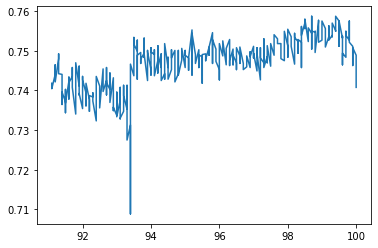

In [10]:
plt.plot(list_percentages_pruned[:-1],list_test_acc_after_pruning)

In [6]:
list_test_acc_after_pruning

[0.740766309975837,
 0.7488781498101484,
 0.750776665516051,
 0.7462892647566448,
 0.7502588885053504,
 0.7511218501898516,
 0.752157404211253,
 0.7575077666551605,
 0.7538833275802554,
 0.7526751812219538,
 0.7538833275802554,
 0.7537107352433552,
 0.7549188816016569,
 0.7483603727994477,
 0.7493959268208491,
 0.7464618570935451,
 0.7537107352433552,
 0.7523299965481532,
 0.7531929582326544,
 0.7575077666551605,
 0.7511218501898516,
 0.7554366586123576,
 0.7575077666551605,
 0.7587159130134622,
 0.7564722126337591,
 0.7549188816016569,
 0.7550914739385571,
 0.7569899896444597,
 0.7535381429064549,
 0.7540559199171557,
 0.7538833275802554,
 0.7526751812219538,
 0.7562996202968588,
 0.7535381429064549,
 0.7535381429064549,
 0.7509492578529513,
 0.7533655505695547,
 0.7514670348636521,
 0.7511218501898516,
 0.7556092509492579,
 0.7575077666551605,
 0.7568173973075596,
 0.7531929582326544,
 0.7526751812219538,
 0.752157404211253,
 0.7576803589920608,
 0.7525025888850535,
 0.75733517431826

In [ ]:
torch.save(model, 'checkpoint_models/pruned_model.pt') 
#save entire model since this is a custom model which would be lost after kernel stops. 
# will have to reprune to get it back. not deterministic. 
#ignore the warning below

In [ ]:
pruned_model=torch.load('checkpoint_models/pruned_model.pt') 
model = pruned_model.cuda()
pruner_obj = PrunningFineTuner_VGG16("train", "test", model)
pruner_obj.test()


### placeholder
ipdb.set_trace()

In [42]:
#future
import os
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset


class Cub2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, loader=default_loader, download=True):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

Cub2011_dataset_train=Cub2011('/scratch/arora.roh/dl_compression/prune2/bird-200-2011', train=True, transform=None, loader=default_loader, download=True)
Cub2011_dataset_test=Cub2011('/scratch/arora.roh/dl_compression/prune2/bird-200-2011', train=False, transform=None, loader=default_loader, download=True)

Files already downloaded and verified
Files already downloaded and verified
